This is where the magic happens...

## Intro

In this notebook I'll work on a model to predict what a tourist will spend when vacationing in Tanzania.
The evaluation metric for the model is **Mean Absolute Error**.

___

We will see that the final model performs 19% better than the baseline model. And it doesn't perform badly in comparison with other submissions to the Zindi Challenge. However, I personally am somehow not completely satisfied. The error still seems very high to me. 

As we have seen, the vast majority of visitors spend less than 2500 EUR on their trip. In these cases, an average deviation of 1700 EUR from the predictions obviously looks pretty bad. On the other hand, we also have some visitors who spend five-digit EUR amounts on the trip. The errors in these predictions naturally push up the mean value.

Since I unfortunately have no possibility to ask anyone about the reliability of the data and its collection and to take measures accordingly, I now accept the result as it is and am happy about a 27th rank in the Zindi Challenge.

___
| Content|
|:---|
|[Basics](#Basics) |
|[Train Test Split](#Train-Test-Split) |
|[Baseline Model Preprocessing](#Preprocessing)|
|[Baseline Model Linear Regression](#Linear-Regression)|
|[Baseline Model Interpretation](#Interpretation)|
|[Modelling Preprocessing](#Preprocessing)|
|[Modelling Build Model XGB Regressor](#Build-Model-XGB-Regressor)|
|[Modelling Hyperparameter Tuning](#Hyperparameter-Tuning)|
|[Modelling Feature Importance](#Feature-Importance)|
|[Conclusion](#Conclusion)|

## Basics

In [1]:
# import some packages that I'll need

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from verstack.stratified_continuous_split import scsplit


# suppress warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

# set color scheme
cpal = ["#f94144","#f3722c","#f8961e","#f9844a","#f9c74f","#90be6d","#43aa8b","#4d908e","#577590","#277da1"]

# seaborn theme
sns.set()

# use natural numbers
pd.options.display.float_format = "{:.2f}".format

# set random seed
RSEED = 42

In [2]:
# load data
TZA = pd.read_csv('data/Train.csv')

# load subregions
subregions = pd.read_csv('data/subregions.csv')
subregions.drop(['Unnamed: 0'], axis=1, inplace=True)

## Train Test Split

I'm going to split the train and test data now, very in the beginning to avoid data leakage.

I'm not using the sklearn train test split as I had concerning results in the first run (much better performance on test than on train data, I assume the different values of the target variable weren't well splitted). That's why I use Verstack stratified continuos split which allows me to stratify by continuos target variable. (It makes sure that different bins of total_cost are evenly divided among train and test data).

In [3]:
# train test split
train, test = scsplit(TZA, stratify = TZA['total_cost'], test_size = 0.3, random_state = RSEED)

## Baseline Model
### Preprocessing

I am going to preprocess the data now. I'll do it separately for train and test data. I start with the very basics for my Baseline Model.

In [4]:
''' function to handle missing data and delete ID column '''

def basic_preprocessing_baseline(df):
    
    # fill NaN total_male/total_female with 0
    df['total_male'] = df['total_male'].fillna(0)
    df['total_female'] = df['total_female'].fillna(0)
    
    # fill NaN travel_with with missing
    df['travel_with'] = df['travel_with'].fillna('missing')
    
    # fill NaN most_impressing with "No comments"
    df['most_impressing'] = df['most_impressing'].fillna('No comments')
   
    # drop id column
    df = df.drop(['ID'], axis =1)
    
    return df

In [5]:
# apply function on train data
train_bl = basic_preprocessing_baseline(train)
# apply function on test data
test_bl = basic_preprocessing_baseline(test)

In [6]:
# separate target variable, both in train and test data

X_train_bl = train_bl.drop(['total_cost'], axis=1)
y_train_bl = train_bl['total_cost']

X_test_bl = test_bl.drop(['total_cost'], axis=1)
y_test_bl = test_bl['total_cost']

Pipelines

I'm going to build some pipelines now. They'll make modelling easier and faster.

I start with a pipeline for the categorical features. I use a One Hot Encoder to convert them into numbers.

In [7]:
# create list of categorical features
cat_features_bl = list(X_train_bl.columns[X_train_bl.dtypes==object])

# build pipeline
cat_pipeline_bl = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown= 'ignore', drop = 'first'))
])

For the numerical features I'll use a Robust Scaler. It can handle outliers pretty good.

In [8]:
# create list of numerical features
num_features_bl = list(X_train_bl.columns[X_train_bl.dtypes!=object])

# build pipeline
num_pipeline_bl = Pipeline([
    ('rob_scaler', RobustScaler())
])

Now I combine them both in a preprocessor.

In [9]:
# combine both pipelines in a preprocessor
preprocessor_bl = ColumnTransformer([
    ('num', num_pipeline_bl, num_features_bl),
    ('cat', cat_pipeline_bl, cat_features_bl)
])

### Linear Regression

First I'm going to train a linear regression model. Except for some NaN we haven't made adjustments on the data yet. The result of the Baseline Model will serve me as a benchmark.

In [10]:
# build pipeline that combines the preprocessor and the linear regression model
pipe_linreg_bl = Pipeline([
    ('preprocessor', preprocessor_bl),
    ('linreg', LinearRegression())
])

In [11]:
# cross validate to check how the model performs on the train data
y_train_predicted_bl_cv = cross_val_predict(pipe_linreg_bl, X_train_bl, y_train_bl, cv=100)

# print MAE of Baseline Model (train data)
print("Mean Absolute Error Baseline Model (train data): {:.2f}".format(mean_absolute_error(y_train_bl, y_train_predicted_bl_cv)))

Mean Absolute Error Baseline Model (train data): 5860776.55


In [12]:
# fit the actual model
y_train_predicted_bl = pipe_linreg_bl.fit(X_train_bl, y_train_bl)

# make predictions for the test data
y_test_predicted_bl = pipe_linreg_bl.predict(X_test_bl)
# print MAE of Baseline Model (test data)
print("Mean Absolute Error Baseline Model (test data): {:.2f}".format(mean_absolute_error(y_test_bl, y_test_predicted_bl)))

Mean Absolute Error Baseline Model (test data): 5896644.58


### Interpretation

The Mean Absolute Error of the Baseline Model is 5896644.58 Tanzanian Schillig TZS.
What does that mean?
The MAE is the sum of absolute errors divided by the sample size $n$ where $y_i$ is the prediction and $x_i$ is the true value:

$$ 
MAE = \frac {\sum_{i=1}^n \vert y_i - x_i \vert} {n}
$$

The MAE uses the same scale as the data, so in this case TZS. 

So, on average, the model's predictions are 5896644.58 TZS off the true value. This is roughly 2173 Euro and seems quite a lot. 

Our aim is to improve (lower) this metric as much as we can.

So let's start with the actual 

## Modelling
### Preprocessing

First I'll make some more adjustments on the dataset - some of them we already saw in the EDA. I want to reduce noise from the dataset and add some more information which seems useful to me. I need a function that I can apply to both the train and the test data.

*** Important ****

*I only show the final version here in the notebook. I have experimented a lot with the various features.*

*The first versions of the model (before hyperparameter tuning) showed extreme overfitting and I tried to reduce the complexity of the model by omitting features - especially since we saw in the EDA that the data is often contradictory.*

*The following changes in the dataset worked best. As it turned out, the model performs best with a relatively large amount of features.*

*We have also seen in the EDA that there are some extreme values for the numerical features. Due to the nature of the data set, I tend to believe that the supposed outliers are very often true values. Nevertheless, I have also tried outlier handling techniques (IQR method, by pertentiles, Isolation Forest) in the course of model building - removing the outliers did not improve the model, so the values remain unchanged. This also indicates to me that these values are mostly correct.*

In [13]:
''' function to handle missing data and to make some adjustments in the data set '''

def adjustments(df):
    # fill NaN total_male/total_female with 0
    df['total_male'] = df['total_male'].fillna(0)
    df['total_female'] = df['total_female'].fillna(0)
    
    # add a column group_size based on total_male/total_female
    df['group_size'] = df['total_female'] + df['total_male']
    
    # fill NaN travel_with with "Alone" if group_size is one
    df.loc[df.group_size == 1, 'travel_with'] = 'Alone'
    
    # fill remaining NaN travel_with with missing
    df['travel_with'] = df['travel_with'].fillna('missing')
    
    # fill NaN most_impressing with "No comments"
    df['most_impressing'] = df['most_impressing'].fillna('No comments')
    
    # add a column total_nights based on night_zanzibar/night_mainland
    df['total_nights'] = df['night_zanzibar'] + df['night_mainland']
    
    # handle group_size equals zero: either replace by 1 if alone traveller or median group size of the train data
    df.loc[(df.group_size == 0) & (df.travel_with == 'Alone'), 'group_size'] = 1
    df.loc[df.group_size == 0, 'group_size'] = train['group_size'].median()

    # handle total_nights equals zero: replace by median total_nights of the train data
    df.loc[df.total_nights == 0, 'total_nights'] = train['total_nights'].median()

    # drop id column
    df = df.drop(['ID'], axis =1)
    
    # drop night_mainland column (to avoid multicollinearity)
    df = df.drop(['night_mainland'], axis =1)
    
    # drop total_male column (to avoid multicollinearity)
    df = df.drop(['total_male'], axis =1)

    # add subregions just as in the EDA
    df['country'] = df['country'].str.lower()
    df = df.replace({'country' : {'united states of america': 'united States', 'swaziland' : 'eswatini', 'cape verde' : 'cabo verde', 'swizerland' : 'switzerland', 'ukrain' : 'ukraine','malt' : 'malta', 'burgaria' : 'bulgaria', 'korea' : 'south korea', 'comoro' : 'comoros', 'scotland' : 'united kingdom', 'russia' : 'russia', 'srilanka': 'sri lanka'}})
    df = df.replace({'country' : {'ivory coast': "côte d'ivoire", 'drc' : 'congo', 'uae' : 'united arab emirates', 'trinidad tobacco' : 'trinidad and tobago', 'costarica' : 'costa rica', 'philipines' : 'philippines', 'djibout' : 'djibouti', 'morroco' : 'morocco'}})
    df['country'] = df['country'].str.capitalize()
    df = pd.merge(df, subregions, how ='left')
    
    return df

This function I now apply to both: the train and the test data.

Missing data or 0 entries in the total_nights and group_size columns are thus imputed with the median of the *train* data.

In [14]:
# apply to train and test data
train_model = adjustments(train)
test_model = adjustments(test)

Now I separate the target variable from the features, for both: train and test data.

In [15]:
# define target variable

X_train = train_model.drop(['total_cost'], axis=1)
y_train = train_model['total_cost']

X_test = test_model.drop(['total_cost'], axis=1)
y_test = test_model['total_cost']

I build a pipeline again and start with the preprocessor

In [16]:
# build pipeline

cat_features = list(X_train.columns[X_train.dtypes==object])

cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown= 'ignore', drop = 'first'))
])

num_features = list(X_train.columns[X_train.dtypes!=object])

num_pipeline = Pipeline([
    ('stand_scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
])

*** Important ***

*I have tried various models:*

***Random Forest** - performed quite well*

***Decision Tree** - showed extreme overfitting*

***KNN** - performed mediocre*

*I achieved the best result with the **XGB Regressor***

### Build Model XGB Regressor

First of all, I do a cross validation.

In [17]:
# pipeline

pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor(subsample= 0.7, n_estimators= 50, min_child_weight= 2, max_depth= 9, learning_rate= 0.05, colsample_bytree= 0.6))
])

# cross validate

y_train_predicted_xgb_cv = cross_val_predict(pipe_xgb, X_train, y_train, cv=5)
print("Mean Absolute Error first XGB (cross validation): {:.2f}".format(mean_absolute_error(y_train, y_train_predicted_xgb_cv)))

Mean Absolute Error first XGB (cross validation): 4932620.31


Now I fit the model and predict the total_cost for the test data. I compute the MAE for both, the train and the test data.

I'm using here the best parameters that the hyperparameter tuning (see below) gave me.

In [18]:
# fit and predict

pipe_xgb.fit(X_train, y_train)

y_train_predicted_xgb = pipe_xgb.predict(X_train)
y_test_predicted_xgb = pipe_xgb.predict(X_test)
print("Mean Absolute Error first XGB (train data): {:.2f}".format(mean_absolute_error(y_train, y_train_predicted_xgb)))
print("Mean Absolute Error first XGB (test data): {:.2f}".format(mean_absolute_error(y_test, y_test_predicted_xgb)))

Mean Absolute Error first XGB (train data): 3499217.97
Mean Absolute Error first XGB (test data): 4768525.07


This is a good improvement compared to the Baseline Model:

|  | Baseline Model | XGB |
|:----------------------|:----------------------|:----------------------|
| MAE (TZS)        | 5896644       | 4768525      |
| MAE (Euro)        | 2159        | 1746        |

The performance was improved by 19%.

### Hyperparameter tuning

As explained earlier, I've tried to train the model with different features: I removed some, created and added new ones, tried different combinations - but at a certain point with little success. If anything, the performance got worse. I seem to have already found the optimum combination of features.

I use Hyperparameter tuning now. RandomizedSearchCV explores a random set of hyperparameter combinations. It selects and evaluates a specified number of these random combinations, identifying the set of hyperparameters that optimize the performance of my model.

First I define the distribution of hyperparameters that the randomized search will sample from:

In [19]:
# create a dictionary with hyperparameters to test
param_grid = {
    'xgb__learning_rate': np.arange(0.05, 0.31, 0.05),
    'xgb__n_estimators': np.arange(50, 200, 50),
    'xgb__max_depth': np.arange(3, 10, 1),
    'xgb__min_child_weight': np.arange(1, 6, 1),
    'xgb__subsample': np.arange(0.6, 1.01, 0.1),
    'xgb__colsample_bytree': np.arange(0.6, 1.01, 0.1)
}

Now I run the search.

In [20]:
# run the search

random_search_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=param_grid, n_iter=10, cv=5,  scoring='neg_mean_absolute_error',random_state=RSEED, n_jobs=-1, verbose=0)
random_search_xgb.fit(X_train, y_train)

/Users/johannakruger/neuefische/Tanzania_Tourism_Prediction/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/johannakruger/neuefische/Tanzania_Tourism_Prediction/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/johannakruger/neuefische/Tanzania_Tourism_Prediction/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/johannakruger/neuefische/Tanzania_Tourism_Prediction/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('stand_scaler',
                                                                                                StandardScaler())]),
                                                                               ['total_female',
                                                                                'night_zanzibar',
                                                                                'group_size',
                                                                                'total_nights']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('1hot',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['country',
                                                                                'age_group',
                                                                                'travel_with',
                                                                                'purpos...
                   n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': array([0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'xgb__learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
                                        'xgb__max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'xgb__min_child_weight': array([1, 2, 3, 4, 5]),
                                        'xgb__n_estimators': array([ 50, 100, 150]),
                                        'xgb__subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_mean_absolute_error')

In [21]:
warnings.resetwarnings()

Let's see which hyperparameters are the optimum for our model:

In [22]:
print("Best Parameters: ", random_search_xgb.best_params_)
print("Best Neg. MAE: ", random_search_xgb.best_score_)

Best Parameters:  {'xgb__subsample': 0.7, 'xgb__n_estimators': 50, 'xgb__min_child_weight': 2, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.05, 'xgb__colsample_bytree': 0.6}
Best Neg. MAE:  -4932567.700846899


With these hyperparameters I go back to my model and run it again.

### Feature Importance

Let's take a look at which features the model found particularly important:

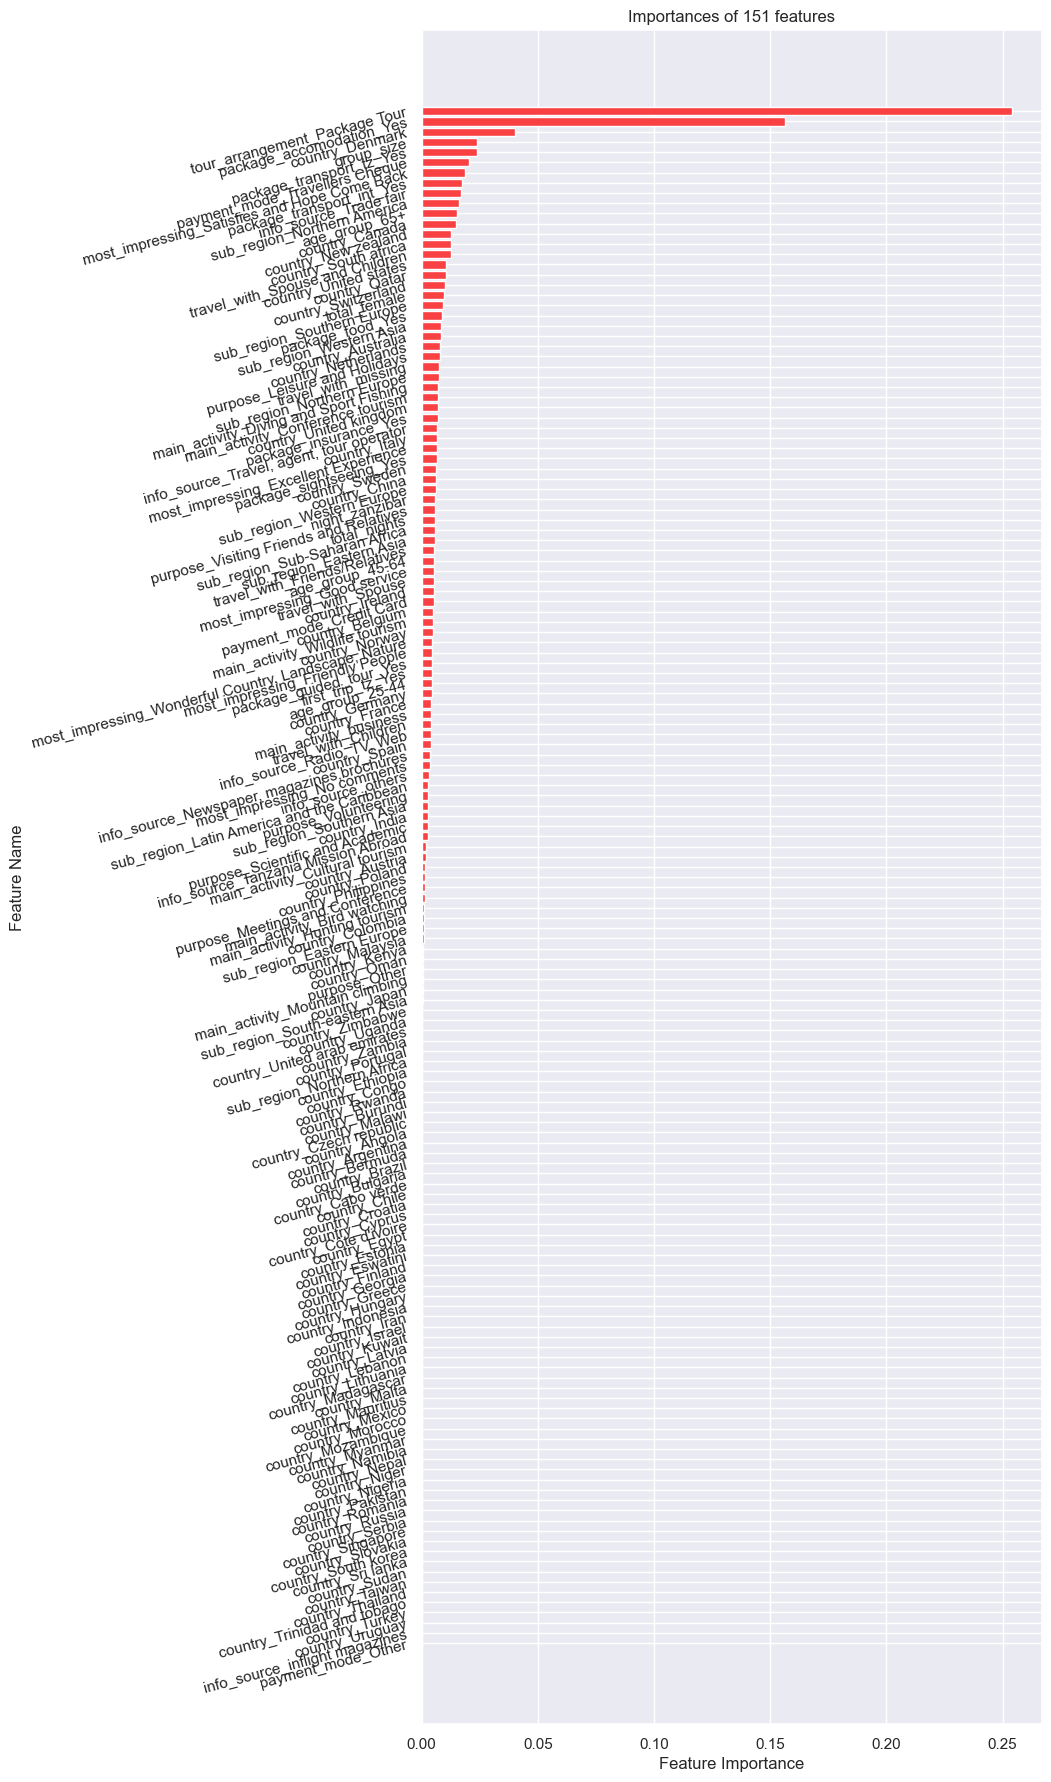

In [23]:
# show feature importance
encoded_cat_features = pipe_xgb['preprocessor'].transformers_[1][1]\
    ['1hot'].get_feature_names_out(cat_features)
feature_names = np.insert(encoded_cat_features,0, num_features)
importances = pipe_xgb.steps[1][1].feature_importances_
sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]
num_features_to_display = len(importances)
top_feature_names = sorted_feature_names[:num_features_to_display]
top_importances = sorted_importances[:num_features_to_display]
plt.figure(figsize=(8, 22))  
plt.barh(top_feature_names, top_importances, color='#f94144')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.yticks(rotation=15)
plt.title('Importances of {} features'.format(num_features_to_display))
plt.gca().invert_yaxis() 
plt.show();

The feature importance does not necessarily tell us anything about the actual relationships between the variables. However, I find it interesting to see that the countries (except Denmark?) are not really important for the model. So it was worth adding the subregions, which was a lot of work for me. (By the way, the model doesn't get any better if you delete the country column).

## Conclusion

I sometimes struggled a little with the data set - because I couldn't improve the model as much as I would have liked. I thought so much about the individual features and kept expanding to the EDA to make it easier to understand, but there were some things I just couldn't figure out. It would have been nice to be able to simply ask someone how the data was actually collected and what it could mean in detail. I also don't know the Tanzanian tourism industry very well. That might have helped.

I had set myself the goal of getting the MAE below 5000000. In the end, I managed to do it, even relatively clearly - thanks to hyperparameter tuning. 